In [47]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as py
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/married-at-first-sight/mafs.csv


In [48]:
df=pd.read_csv("../input//married-at-first-sight/mafs.csv")
df.head(10)

,Couple,Season,Location,Name,Age,Gender,Occupation,Decision,Status,DrPepperSchwartz,DrLoganLevkoff,DrJosephCilona,ChaplainGregEpstein,PastorCalvinRoberson,RachelDeAlto,DrJessicaGriffin,DrVivianaColes
0,1,1,New York City and Northern New Jersey,Jamie Otis-Hehner,27,F,Nurse,Yes,Married,1,1,1,1,0,0,0,0
1,1,1,New York City and Northern New Jersey,Doug Hehner,31,M,Software salesman,Yes,Married,1,1,1,1,0,0,0,0
2,2,1,New York City and Northern New Jersey,Cortney Hendrix,26,F,Make-up artist,Yes,Divorced,1,1,1,1,0,0,0,0
3,2,1,New York City and Northern New Jersey,Jason Carrion,27,M,Fireman,Yes,Divorced,1,1,1,1,0,0,0,0
4,3,1,New York City and Northern New Jersey,Monet Bell,33,F,Product development manager,No,Divorced,1,1,1,1,0,0,0,0
5,3,1,New York City and Northern New Jersey,Vaughn Copeland,30,M,Field service technician,No,Divorced,1,1,1,1,0,0,0,0
6,4,2,New York City and Northern New Jersey,Jaclyn Methuen,30,F,Vodka saleswoman,Yes,Divorced,1,1,1,1,0,0,0,0
7,4,2,New York City and Northern New Jersey,Ryan Ranellone,28,M,Real estate agent,Yes,Divorced,1,1,1,1,0,0,0,0
8,5,2,New York City and Northern New Jersey,Davina Kullar (now Davis),34,F,Pharmaceutical saleswoman,No,Divorced,1,1,1,1,0,0,0,0
9,5,2,New York City and Northern New Jersey,Sean Varricchio,35,M,Trauma nurse,No,Divorced,1,1,1,1,0,0,0,0


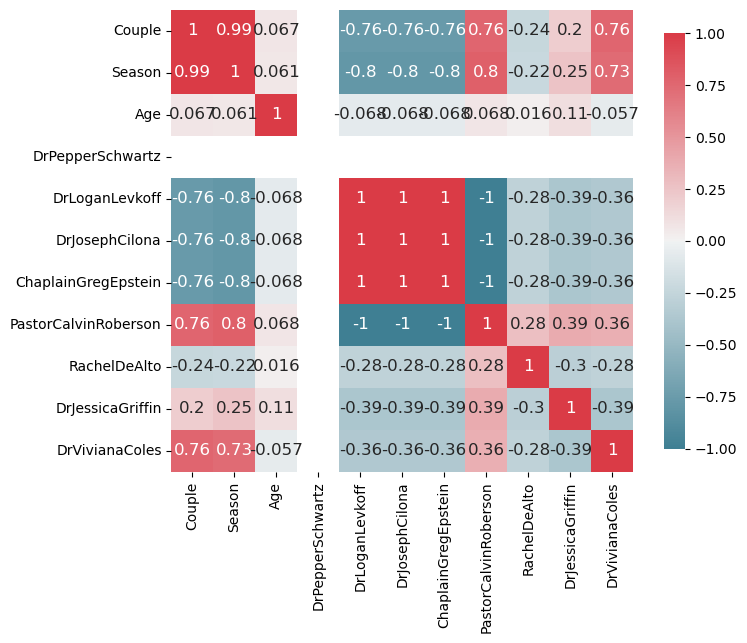

In [49]:
def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 8 , 6 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

plot_correlation_map(df) 

In [50]:
fig = px.box(df, x="Couple", y="Age", points="all")
fig.show()

In [51]:
corr=df[df.columns.sort_values()].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig = go.Figure(data=go.Heatmap(z=corr.mask(mask),
                                x=corr.columns.values,
                                y=corr.columns.values,
                                xgap=1, ygap=1,
                                colorscale="Rainbow",
                                colorbar_thickness=20,
                                colorbar_ticklen=3,
                                zmid=0),
                layout = go.Layout(title_text='Correlation Matrix', template='plotly_dark',
                height=900,
                xaxis_showgrid=False,
                yaxis_showgrid=False,
                yaxis_autorange='reversed'))
fig.show()

In [52]:
import shap
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import random

In [53]:
df.isnull().sum()

Couple                  0
Season                  0
Location                0
Name                    0
Age                     0
Gender                  0
Occupation              0
Decision                0
Status                  0
DrPepperSchwartz        0
DrLoganLevkoff          0
DrJosephCilona          0
ChaplainGregEpstein     0
PastorCalvinRoberson    0
RachelDeAlto            0
DrJessicaGriffin        0
DrVivianaColes          0
dtype: int64

In [54]:
df['Location'] = df['Location'].replace(['Decision','DrJosephCilona'], [0,1])

In [55]:
SEED = 99
random.seed(SEED)
np.random.seed(SEED)

In [56]:
dfmodel = df.copy()

# read the "object" columns and use labelEncoder to transform to numeric
for col in dfmodel.columns[dfmodel.dtypes == 'object']:
    le = LabelEncoder()
    dfmodel[col] = dfmodel[col].astype(str)
    le.fit(dfmodel[col])
    dfmodel[col] = le.transform(dfmodel[col])

In [57]:
#change columns names to alphanumeric
dfmodel.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in dfmodel.columns]

In [58]:
#change columns names to alphanumeric
dfmodel.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in dfmodel.columns]

In [59]:
X = dfmodel.drop(['Location','Couple'], axis = 1)
y = dfmodel['Location']

In [60]:
lgb_params = {
                    'objective':'binary',
                    'metric':'auc',
                    'n_jobs':-1,
                    'learning_rate':0.005,
                    'num_leaves': 20,
                    'max_depth':-1,
                    'subsample':0.9,
                    'n_estimators':2500,
                    'seed': SEED,
                    'early_stopping_rounds':100, 
                }

In [61]:
# choose the number of folds, and create a variable to store the auc values and the iteration values.
K = 5
folds = KFold(K, shuffle = True, random_state = SEED)
best_scorecv= 0
best_iteration=0

# Separate data in folds, create train and validation dataframes, train the model and cauculate the mean AUC.
for fold , (train_index,test_index) in enumerate(folds.split(X, y)):
    print('Fold:',fold+1)
          
    X_traincv, X_testcv = X.iloc[train_index], X.iloc[test_index]
    y_traincv, y_testcv = y.iloc[train_index], y.iloc[test_index]
    
    train_data = lgb.Dataset(X_traincv, y_traincv)
    val_data   = lgb.Dataset(X_testcv, y_testcv)
    
    LGBM = lgb.train(lgb_params, train_data, valid_sets=[train_data,val_data], verbose_eval=250)
    best_scorecv += LGBM.best_score['valid_1']['auc']
    best_iteration += LGBM.best_iteration

best_scorecv /= K
best_iteration /= K
print('\n Mean AUC score:', best_scorecv)
print('\n Mean best iteration:', best_iteration)

Fold: 1
[LightGBM] [Info] Number of positive: 50, number of negative: 4
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 63
[LightGBM] [Info] Number of data points in the train set: 54, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.925926 -> initscore=2.525729
[LightGBM] [Info] Start training from score 2.525729
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

In [62]:
lgb_params = {
                    'objective':'binary',
                    'metric':'auc',
                    'n_jobs':-1,
                    'learning_rate':0.05,
                    'num_leaves': 20,
                    'max_depth':-1,
                    'subsample':0.9,
                    'n_estimators':round(best_iteration),
                    'seed': SEED,
                    'early_stopping_rounds':None, 
                }

train_data_final = lgb.Dataset(X, y)
LGBM = lgb.train(lgb_params, train_data)

[LightGBM] [Info] Number of positive: 49, number of negative: 6
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 63
[LightGBM] [Info] Number of data points in the train set: 55, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.890909 -> initscore=2.100061
[LightGBM] [Info] Start training from score 2.100061
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

In [63]:
print(LGBM)

In [64]:
# telling wich model to use
explainer = shap.TreeExplainer(LGBM)
# Calculating the Shap values of X features
shap_values = explainer.shap_values(X)

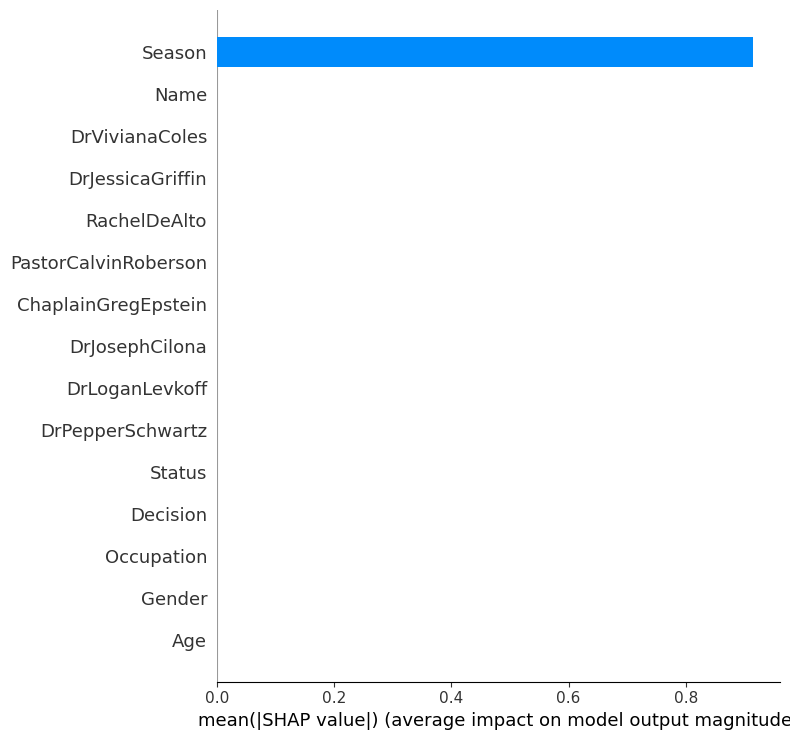

In [65]:
shap.summary_plot(shap_values[1], X, plot_type="bar")

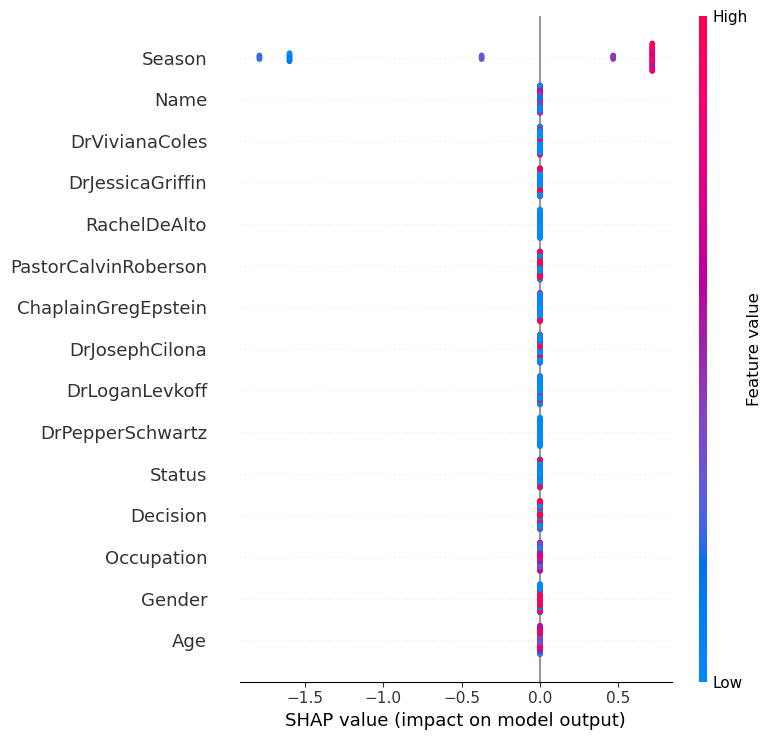

In [66]:
shap.summary_plot(shap_values[1], X)

In [67]:
fig = px.scatter_matrix(df, dimensions=["Couple", "Season", "Age", "RachelDeAlto"], color="Location")
fig.show()